In [330]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,multilabel_confusion_matrix
import cv2
from tensorflow import keras
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import layers, models, regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.semi_supervised import LabelPropagation
from torchstat import stat

In [2]:
print(torch.backends.mps.is_built())

True


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Set memory limit
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set the desired memory limit (in MB)
    except RuntimeError as e:
        print(e)


In [5]:
torch.set_default_device(0)

## Data loading and exploration

In [6]:
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [7]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [8]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [10]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

In [11]:
data['Labels'].value_counts()

Labels
Lung Adenocarcinoma             5000
Colon Benign Tissue             5000
Colon Adenocarcinoma            5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Name: count, dtype: int64

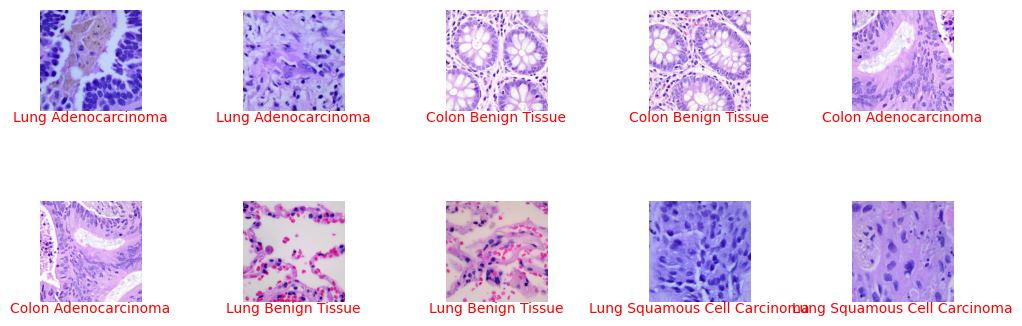

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = plt.imread(filepath)

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    annotation_x = 768 // 2
    annotation_y = 768 + 2
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Preprocessing

In [13]:
traindf,validationdf = train_test_split(data,random_state=25,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,random_state=25,train_size=0.5 ,stratify = validationdf['Labels'])

In [14]:
traindf["Labels"].value_counts()

Labels
Colon Benign Tissue             4000
Lung Squamous Cell Carcinoma    4000
Colon Adenocarcinoma            4000
Lung Benign Tissue              4000
Lung Adenocarcinoma             4000
Name: count, dtype: int64

In [15]:
validationdf['Labels'].value_counts()

Labels
Lung Adenocarcinoma             500
Lung Squamous Cell Carcinoma    500
Colon Benign Tissue             500
Colon Adenocarcinoma            500
Lung Benign Tissue              500
Name: count, dtype: int64

In [16]:
testdf['Labels'].value_counts()

Labels
Lung Benign Tissue              500
Colon Adenocarcinoma            500
Lung Squamous Cell Carcinoma    500
Colon Benign Tissue             500
Lung Adenocarcinoma             500
Name: count, dtype: int64

In [18]:

# Set the batch size and image dimensions
image_size = (64, 64)  # Adjust this according to your image size

# Create the ImageDataGenerator objects
datagen = ImageDataGenerator(rescale=1.0 / 255)


In [19]:
train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    validationdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [332]:
def get_data_from_generator(generator):
    num_samples = generator.samples

    # Initialize empty arrays to store the features and labels
    X = []
    y = []

    # Iterate over all the batches and collect the features and labels
    for _ in range(num_samples // generator.batch_size):
        batch_X, batch_y = generator.next()
        X.extend(batch_X)
        y.extend(batch_y)

    # Convert the collected data to numpy arrays
    X = np.array(X)
    y = np.argmax(y,axis=1)

    # Reshape the image data if needed
    if len(X.shape) > 2:
        X = X.reshape(-1, *X.shape[1:])

    return X.reshape(X.shape[0], -1), y


In [333]:
print("TRAIN:")
trainX,trainY = get_data_from_generator(train_generator)
print(len(trainX),len(trainY))

print("VALIDATION:")
validationX,validationY = get_data_from_generator(validation_generator)
print(len(validationX),len(validationY))

print("TEST:")
testX,testY = get_data_from_generator(test_generator)
print(len(testX),len(testY))
print(len(trainX[0]))

TRAIN:
20000 20000
VALIDATION:
2500 2500
TEST:
2500 2500
12288


## DEPTH 5

In [261]:
clf1 = DecisionTreeClassifier(max_depth=5,criterion='entropy',min_samples_split=100)
clf1.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=100)

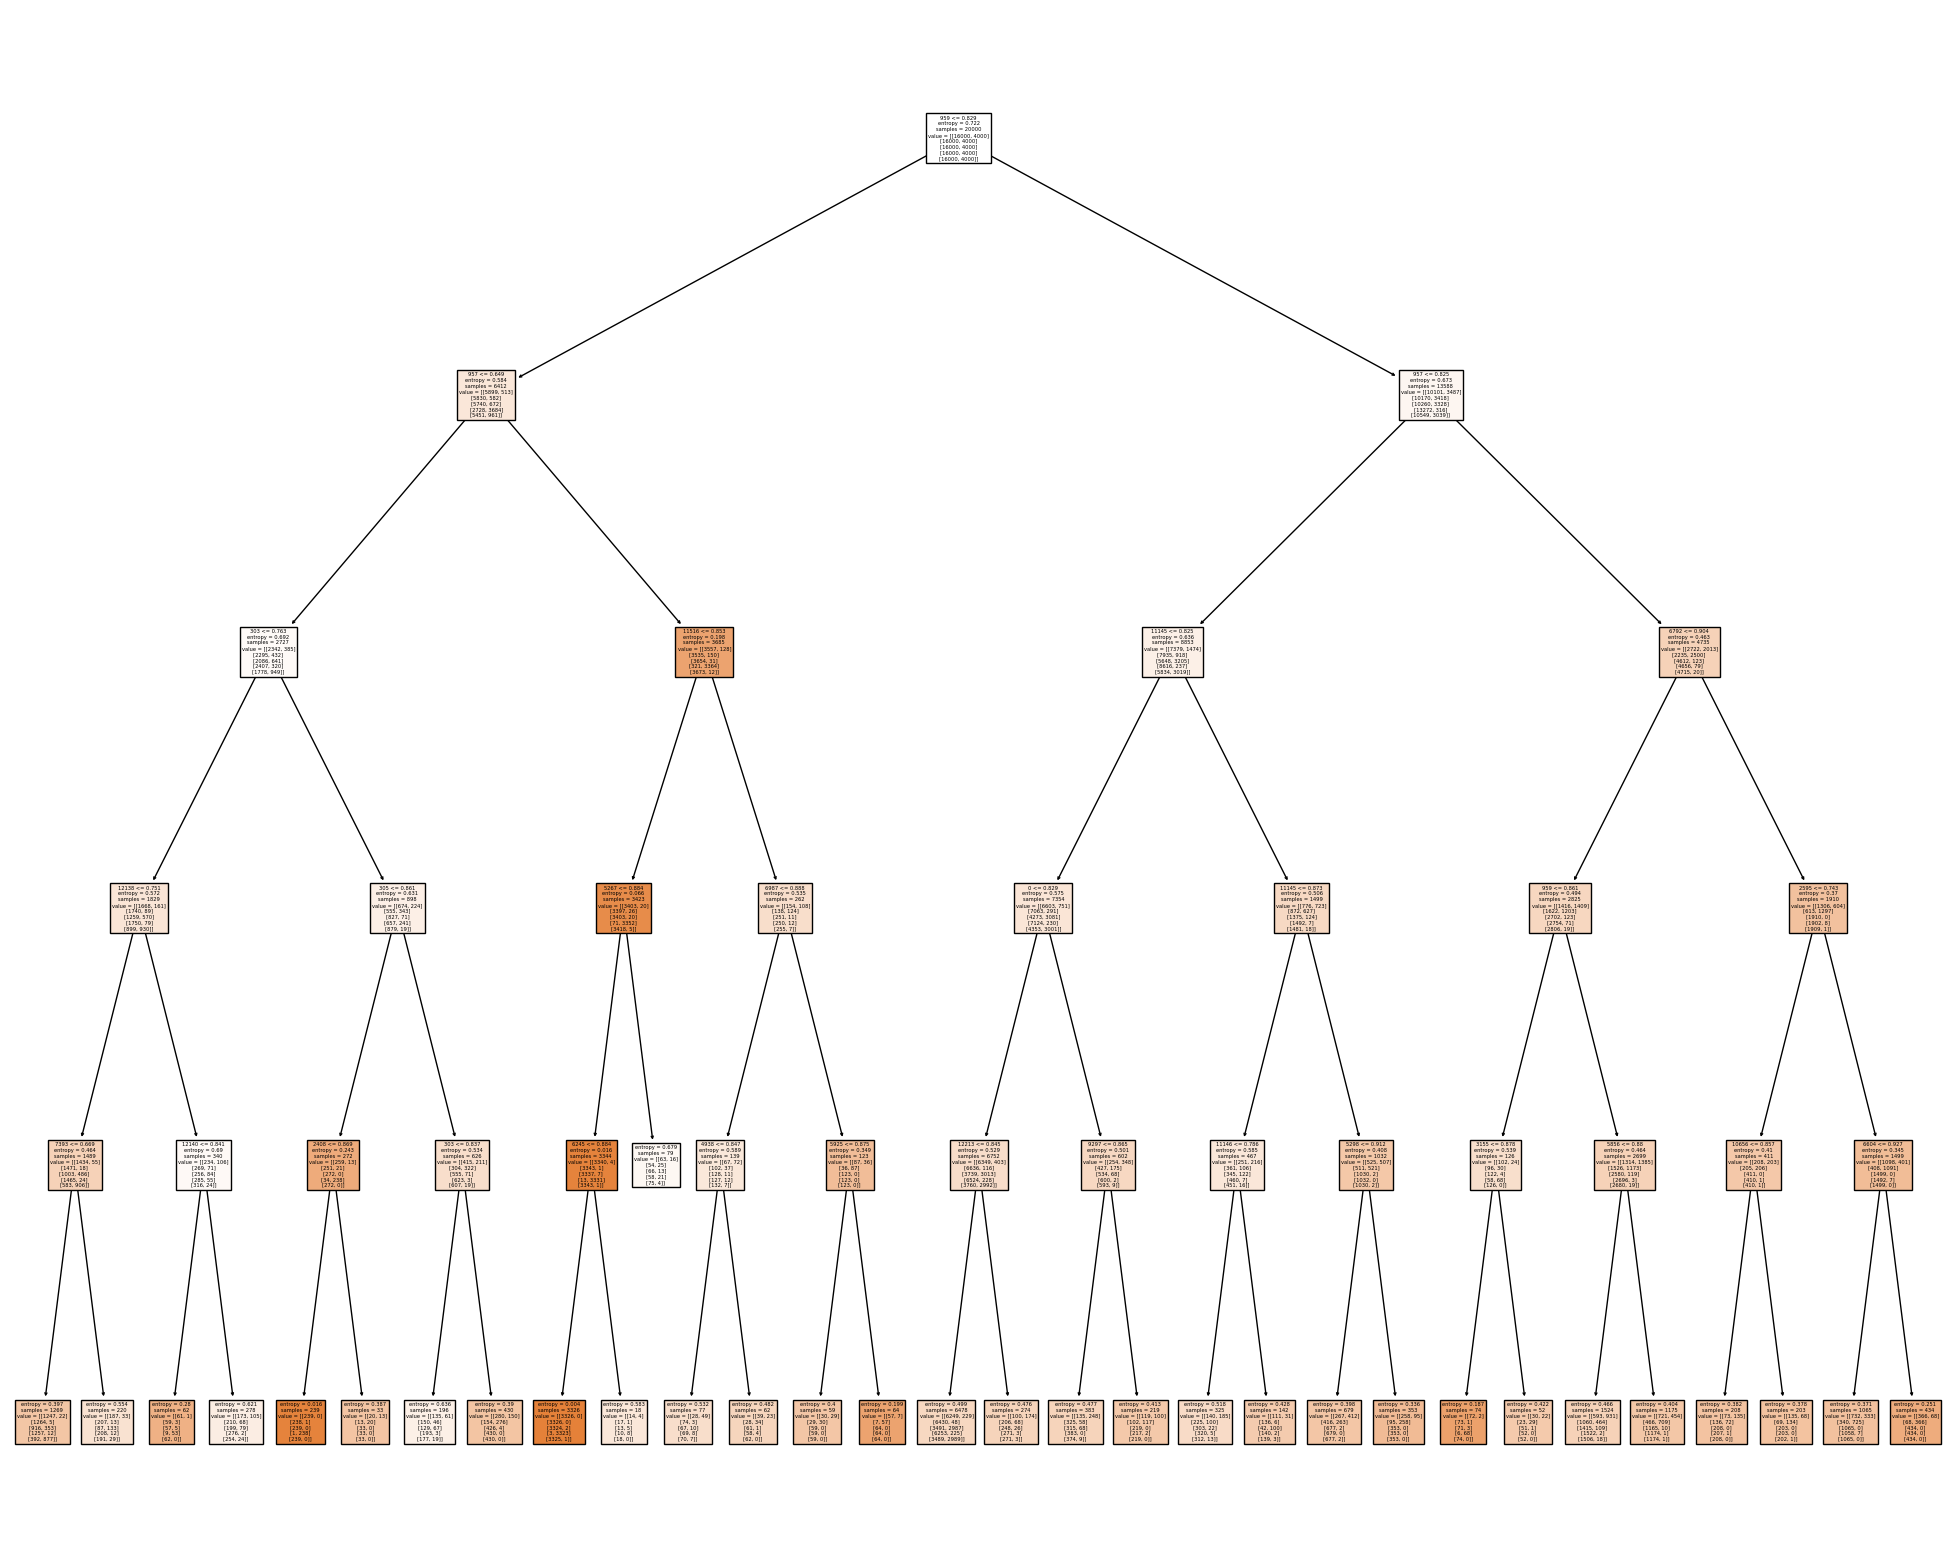

In [24]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
feature_names = [str(i) for i in range(trainX.shape[1])] 
class_names = [str(label) for label in train_generator.classes]  # Convert class labels to strings
_ = tree.plot_tree(clf1,
                   feature_names=feature_names,
                   class_names=class_names,
                   filled=True)

In [262]:
y_val_pred1 = clf1.predict(validationX)
val_accuracy1 = accuracy_score(validationY, y_val_pred1)

# Evaluate the model on the test set
y_test_pred1 = clf1.predict(testX)
test_accuracy1 = accuracy_score(testY, y_test_pred1)

print("Validation Accuracy:", val_accuracy1)
print("Test Accuracy:", test_accuracy1)
print("Train Accuracy:",accuracy_score(trainY,clf1.predict(trainX)))

Validation Accuracy: 0.6128
Test Accuracy: 0.6036
Train Accuracy: 0.62265


In [265]:
predict_result = clf1.predict(trainX)
predict_prob = clf1.predict_proba(trainX)
print(np.array(predict_prob).shape)
print(predict_prob)
print(predict_result[0])

(20000, 5)
[[0.56923077 0.30769231 0.06769231 0.01538462 0.04      ]
 [0.03535042 0.00740969 0.4610991  0.03473294 0.46140784]
 [0.03535042 0.00740969 0.4610991  0.03473294 0.46140784]
 ...
 [0.03535042 0.00740969 0.4610991  0.03473294 0.46140784]
 [0.03535042 0.00740969 0.4610991  0.03473294 0.46140784]
 [0.03535042 0.00740969 0.4610991  0.03473294 0.46140784]]
0


In [27]:
report = classification_report(testY, y_test_pred1,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.52      0.54       500
           1       0.64      0.64      0.64       500
           2       0.59      0.05      0.10       500
           3       0.99      0.88      0.93       500
           4       0.65      0.23      0.34       500

   micro avg       0.72      0.46      0.56      2500
   macro avg       0.69      0.46      0.51      2500
weighted avg       0.69      0.46      0.51      2500
 samples avg       0.46      0.46      0.46      2500



In [266]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create the decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameter grid
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [7,9],
    'min_samples_split': [100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(trainX, trainY)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(testX)

Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 100}
Best Score: 0.71565


In [267]:
y_val_pred2 = best_model.predict(validationX)
val_accuracy2 = accuracy_score(validationY, y_val_pred2)

# Evaluate the model on the test set
y_test_pred2 = best_model.predict(testX)
test_accuracy2 = accuracy_score(testY, y_test_pred2)

print("Validation Accuracy:", val_accuracy2)
print("Test Accuracy:", test_accuracy2)
print("Train Accuracy:",accuracy_score(trainY,best_model.predict(trainX)))

Validation Accuracy: 0.726
Test Accuracy: 0.7096
Train Accuracy: 0.78465


In [ ]:
predict_result = clf1.predict(trainX[0])
plt.imshow()
predict_prob = clf1.predict_proba(trainX)
print(np.array(predict_prob).shape)
print(predict_prob[0][0][1])
print(predict_prob[1][0][1])
print(predict_prob[2][0][1])
print(predict_prob[3][0][1])
print(predict_prob[4][0][1])
print(predict_result[0])

## DEPTH 10

In [268]:
clf2 = DecisionTreeClassifier(max_depth=10,criterion='entropy',min_samples_split=100)
clf2.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=100)

In [269]:
y_val_pred2 = clf2.predict(validationX)
val_accuracy2 = accuracy_score(validationY, y_val_pred2)

# Evaluate the model on the test set
y_test_pred2 = clf2.predict(testX)
test_accuracy2 = accuracy_score(testY, y_test_pred2)

print("Validation Accuracy:", val_accuracy2)
print("Test Accuracy:", test_accuracy2)
print("Train Accuracy:",accuracy_score(trainY,clf2.predict(trainX)))

Validation Accuracy: 0.7236
Test Accuracy: 0.7148
Train Accuracy: 0.8002


In [270]:
report = classification_report(testY, y_test_pred2,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       500
           1       0.64      0.66      0.65       500
           2       0.69      0.57      0.63       500
           3       0.97      0.93      0.95       500
           4       0.68      0.81      0.74       500

    accuracy                           0.71      2500
   macro avg       0.72      0.71      0.71      2500
weighted avg       0.72      0.71      0.71      2500



## DEPTH 15

In [271]:
clf3 = DecisionTreeClassifier(max_depth=15,criterion='entropy',min_samples_split=100)
clf3.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=100)

In [272]:
y_val_pred3 = clf3.predict(validationX)
val_accuracy3 = accuracy_score(validationY, y_val_pred3)

# Evaluate the model on the test set
y_test_pred3 = clf3.predict(testX)
test_accuracy3 = accuracy_score(testY, y_test_pred3)

print("Validation Accuracy:", val_accuracy3)
print("Test Accuracy:", test_accuracy3)
print("Train Accuracy:",accuracy_score(trainY,clf3.predict(trainX)))

Validation Accuracy: 0.7332
Test Accuracy: 0.7288
Train Accuracy: 0.82955


In [273]:
report = classification_report(testY, y_test_pred3,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       500
           1       0.65      0.66      0.65       500
           2       0.70      0.66      0.68       500
           3       0.98      0.92      0.95       500
           4       0.74      0.80      0.77       500

    accuracy                           0.73      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.73      0.73      0.73      2500



## DEPTH 15 : GINI

In [274]:
clf4 = DecisionTreeClassifier(max_depth=15,criterion='gini',min_samples_split=100)
clf4.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=15, min_samples_split=100)

In [275]:
y_val_pred = clf4.predict(validationX)
val_accuracy = accuracy_score(validationY, y_val_pred)

# Evaluate the model on the test set
y_test_pred = clf4.predict(testX)
test_accuracy = accuracy_score(testY, y_test_pred)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:",accuracy_score(trainY,clf4.predict(trainX)))

Validation Accuracy: 0.7464
Test Accuracy: 0.7316
Train Accuracy: 0.86275


## DEPTH: UNDEFINED

In [276]:
clf = DecisionTreeClassifier(criterion='entropy',min_samples_split=100)
clf.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', min_samples_split=100)

In [277]:
y_val_pred4 = clf.predict(validationX)
clf_val_accuracy4 = accuracy_score(validationY, y_val_pred4)

# Evaluate the model on the test set
y_test_pred4 = clf.predict(testX)
clf_test_accuracy4 = accuracy_score(testY, y_test_pred4)

print("Validation Accuracy:", clf_val_accuracy4)
print("Test Accuracy:", clf_test_accuracy4)
print("Train Accuracy:",accuracy_score(trainY,clf.predict(trainX)))

Validation Accuracy: 0.7408
Test Accuracy: 0.7328
Train Accuracy: 0.84175


In [279]:
report = classification_report(testY, y_test_pred4,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       500
           1       0.65      0.66      0.66       500
           2       0.71      0.68      0.69       500
           3       0.97      0.92      0.95       500
           4       0.74      0.79      0.76       500

    accuracy                           0.73      2500
   macro avg       0.74      0.73      0.73      2500
weighted avg       0.74      0.73      0.73      2500



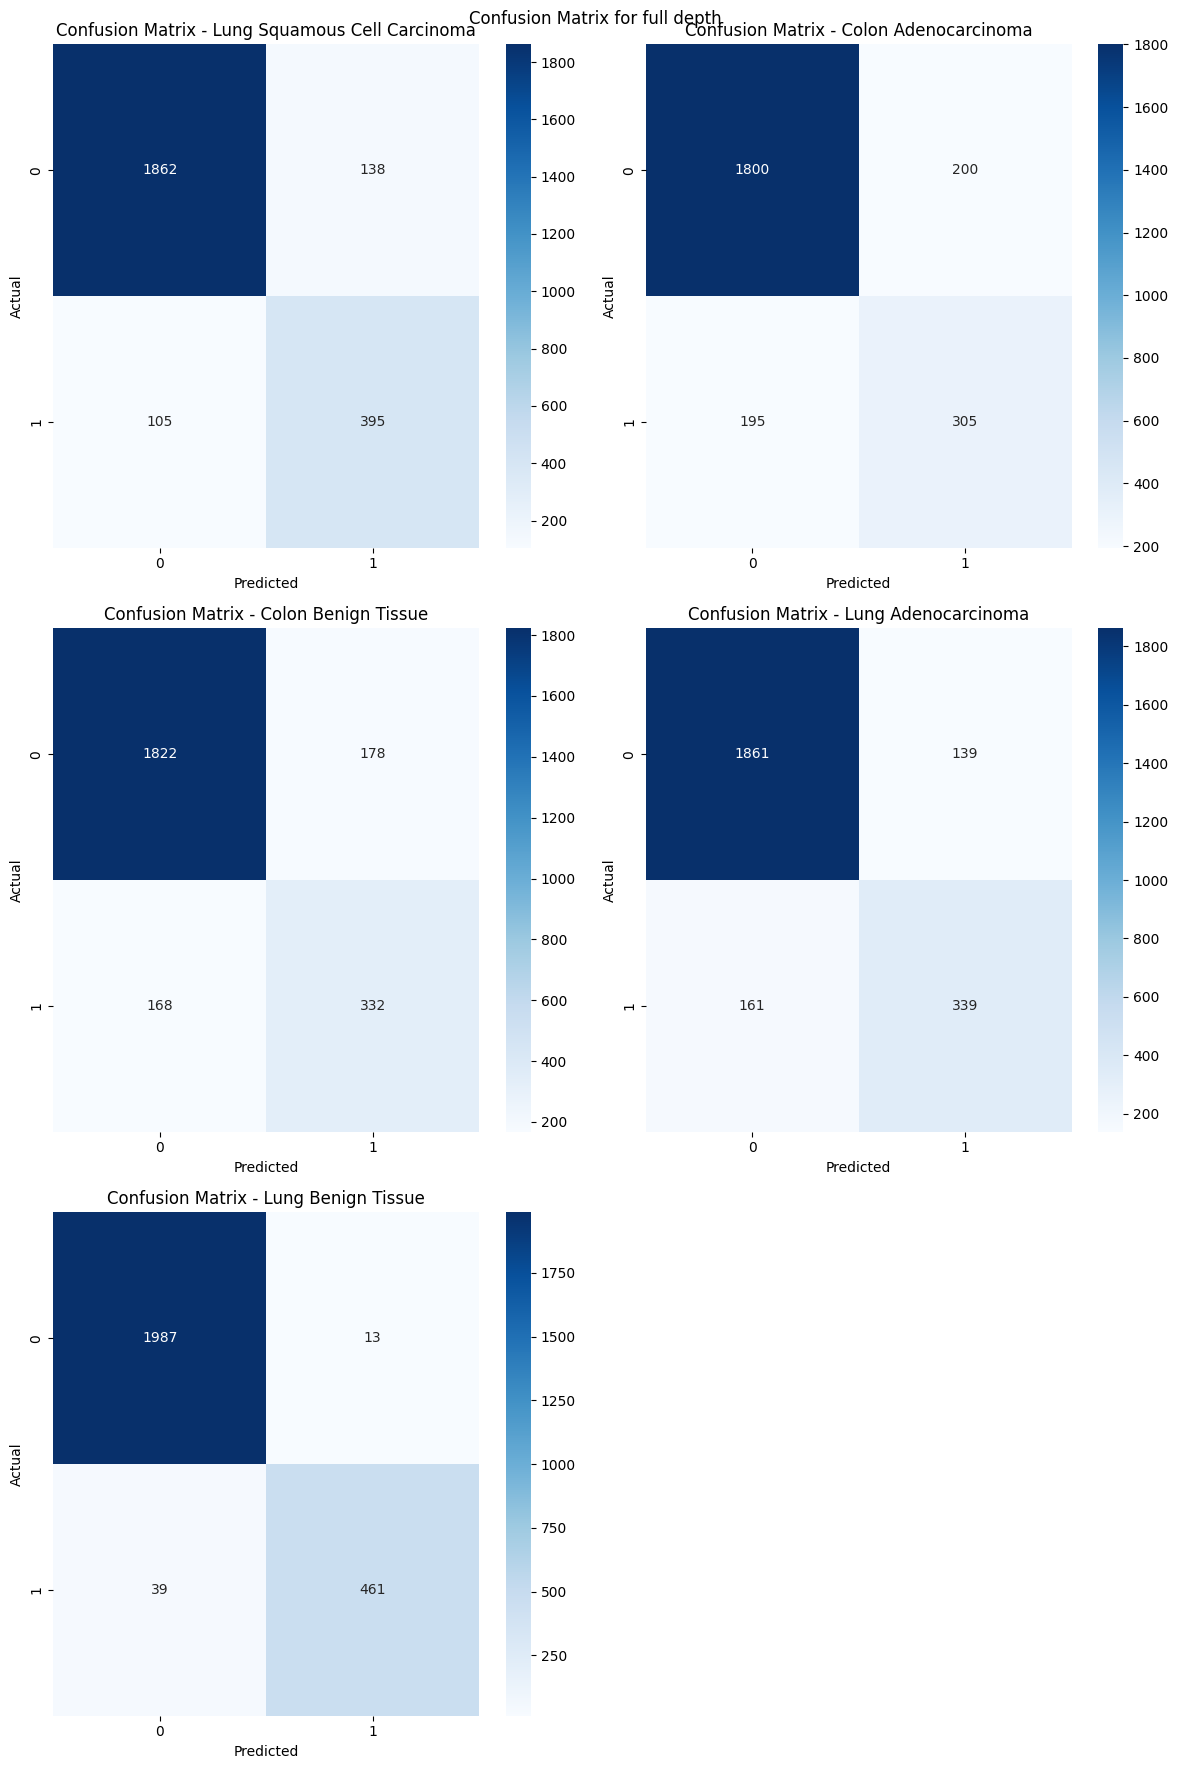

In [280]:
cnf_matrix = multilabel_confusion_matrix(testY, y_test_pred4)
np.set_printoptions(precision=2)
num_labels = len(cnf_matrix)

# Calculate the number of rows and columns needed based on the available labeled data
num_rows = (num_labels+1) // 2
num_cols = min(2, num_labels)

# Plotting the confusion matrix
fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(12, 6*num_rows))
labels = list(test_generator.class_indices.keys()) # Replace with your label names

for i,ax in enumerate(axes.flat):
    if i < num_labels:
        sns.heatmap(cnf_matrix[i-1], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {labels[i-1]}')
    else:
        # Remove any unused subplots
        fig.delaxes(ax)

plt.suptitle("Confusion Matrix for full depth")
plt.tight_layout()
plt.show()

In [281]:
tree_depth = clf.tree_.max_depth
print("Depth of the decision tree:", tree_depth)

Depth of the decision tree: 32


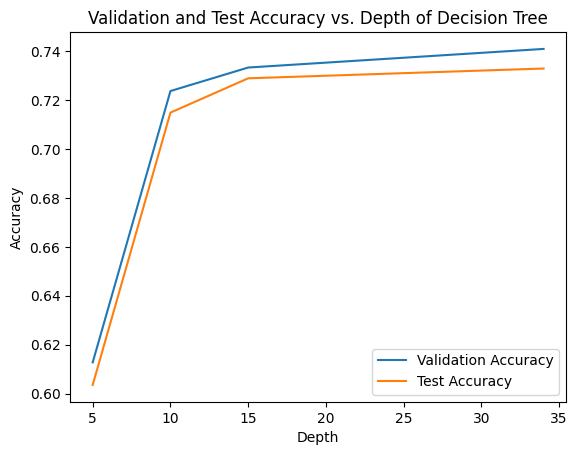

In [282]:
# Plot add
depths = [5,10,15,34]
val_accuracy = [val_accuracy1,val_accuracy2,val_accuracy3,clf_val_accuracy4]
test_accuracy = [test_accuracy1,test_accuracy2,test_accuracy3,clf_test_accuracy4] 

plt.plot(depths, val_accuracy, label='Validation Accuracy')
plt.plot(depths, test_accuracy, label='Test Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy vs. Depth of Decision Tree')
plt.legend()
plt.show()

In [283]:
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure()

fig.add_trace(go.Scatter(x=depths, y=val_accuracy, mode='lines', name='Validation Accuracy'))
fig.add_trace(go.Scatter(x=depths, y=test_accuracy, mode='lines', name='Test Accuracy'))

fig.update_layout(
    xaxis_title='Depth',
    yaxis_title='Accuracy',
    title='Validation and Test Accuracy vs. Depth of Decision Tree',
    legend=dict(x=0.7, y=0.9),
    showlegend=True
)

fig.show(renderer='browser')
pio.write_html(fig, file='plot.html', auto_open=True)

## Semi Supervised Decision Tree

In [308]:
X_train_lab, X_train_unlab,y_train_lab,y_train_unlab = train_test_split(trainX,trainY, test_size=0.75, stratify=trainY)

In [299]:
X_train_lab

array([[0.93, 0.93, 0.91, ..., 0.89, 0.78, 0.97],
       [0.66, 0.61, 0.88, ..., 0.81, 0.78, 0.95],
       [0.84, 0.82, 0.78, ..., 0.82, 0.8 , 0.79],
       ...,
       [0.99, 0.98, 0.96, ..., 0.67, 0.47, 0.82],
       [0.57, 0.47, 0.95, ..., 0.66, 0.56, 1.  ],
       [0.29, 0.01, 0.69, ..., 1.  , 0.95, 0.96]], dtype=float32)

In [300]:
y_train_lab

array([0, 4, 3, ..., 0, 2, 1])

In [301]:
X_trainlab.shape #10k labelled

(5000,)

In [302]:
X_trainunlab.shape

(15000,)

In [303]:
y_trainunlab.shape

(15000,)

In [304]:
y_trainlab.shape

(5000,)

In [305]:
dt = DecisionTreeClassifier(max_depth = 9, criterion='entropy',min_samples_split=100)
dt.fit(X_train_lab,y_train_lab)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=100)

In [306]:
y_pred = dt.predict(testX)
test_acc = accuracy_score(testY, y_pred)
print("TEST ACCURACY IN ITERATION: "+" IS: "+str(test_acc))
print("TRAIN ACCURACY IN ITERATION: "+" IS: "+str(accuracy_score(y_train_lab,dt.predict(X_train_lab))))


TEST ACCURACY IN ITERATION:  IS: 0.6496
TRAIN ACCURACY IN ITERATION:  IS: 0.7828


In [310]:
iteration = 0
while(X_train_unlab.shape > 0):
    # Train the model using the labeled data
    dt.fit(X_train_lab, y_train_lab)
    # Make predictions on the unlabeled data
    y_pred = dt.predict(X_train_unlab)
    print(y_train_unlab.shape)
    test_acc = accuracy_score(y_train_unlab, y_pred)
    print("TEST ACCURACY IN ITERATION: "+str(iteration)+" IS: "+str(test_acc))
    print("TRAIN ACCURACY IN ITERATION: "+str(iteration)+" IS: "+str(accuracy_score(y_train_lab,dt.predict(X_train_lab))))

    # Select a subset of the unlabeled data to label
    num_samples_to_label = 0.25 * X_train_unlab.shape[0]
    indices_to_label = np.random.choice(len(X_train_unlab), int(num_samples_to_label), replace=False)
    # Estimate the confidence of unlabeled samples using the predicted class probabilities
    confident_subset = []
    for idx in indices_to_label:
        confidence = np.max(dt.predict_proba(X_train_unlab[idx].reshape(1, -1)))
        if confidence >= 0.7:
            confident_subset.append(X_train_unlab[idx])

    # Convert the confident subset to a numpy array
    confident_subset = np.array(confident_subset)
    print(confident_subset.shape)
    # Add the newly labeled samples to the labeled dataset
    X_train_lab = np.concatenate((X_train_lab, confident_subset))
    y_train_lab = np.concatenate((y_train_lab, dt.predict(confident_subset)))
    # Remove the newly labeled samples from the unlabeled dataset
    X_train_unlab = np.delete(X_train_unlab , indices_to_label,axis =0)
    y_train_unlab = np.delete(y_train_unlab, indices_to_label,axis=0)
    print("X_LABEL: "+str(X_train_unlab.shape)+"Y_UNLABEL: "+str(y_train_unlab.shape))
    iteration += 1

(15000,)
TEST ACCURACY IN ITERATION: 0 IS: 0.6810666666666667
TRAIN ACCURACY IN ITERATION: 0 IS: 0.792
(2828, 12288)
X_LABEL: (11250, 12288)Y_UNLABEL: (11250,)
(11250,)
TEST ACCURACY IN ITERATION: 1 IS: 0.6774222222222223
TRAIN ACCURACY IN ITERATION: 1 IS: 0.842360756259581
(2119, 12288)
X_LABEL: (8438, 12288)Y_UNLABEL: (8438,)
(8438,)
TEST ACCURACY IN ITERATION: 2 IS: 0.6796634273524532
TRAIN ACCURACY IN ITERATION: 2 IS: 0.8776515532321303
(1635, 12288)
X_LABEL: (6329, 12288)Y_UNLABEL: (6329,)
(6329,)
TEST ACCURACY IN ITERATION: 3 IS: 0.6786222151998736
TRAIN ACCURACY IN ITERATION: 3 IS: 0.8925919530305647
(1199, 12288)
X_LABEL: (4747, 12288)Y_UNLABEL: (4747,)
(4747,)
TEST ACCURACY IN ITERATION: 4 IS: 0.6795871076469349
TRAIN ACCURACY IN ITERATION: 4 IS: 0.9031374696815586
(921, 12288)
X_LABEL: (3561, 12288)Y_UNLABEL: (3561,)
(3561,)
TEST ACCURACY IN ITERATION: 5 IS: 0.6778994664420107
TRAIN ACCURACY IN ITERATION: 5 IS: 0.9086994599328565
(662, 12288)
X_LABEL: (2671, 12288)Y_UNLABEL: 

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [314]:
X_train_lab.shape

(16368, 12288)

In [315]:
y_train_lab.shape

(16368,)

In [316]:
20000-16368

3632

In [325]:
ndt = DecisionTreeClassifier(max_depth = 9, criterion='entropy',min_samples_split=100)
ndt.fit(X_train_lab,y_train_lab)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=100)

In [318]:
testY

array([3, 0, 4, ..., 4, 1, 2])

In [326]:
test_accuracy = accuracy_score(testY,ndt.predict(testX))
print(test_accuracy)

0.6636


In [327]:
train_accuracy = accuracy_score(trainY,ndt.predict(trainX))
print(train_accuracy)

0.7109


# CNN

In [284]:
model = models.Sequential()

model.add(layers.Conv2D(32 ,(3,3) , padding = 'same' , input_shape = (64,64,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(512 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(1024 ,(3,3) , padding = 'same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512 , activation='relu' ))
model.add(layers.Dense(5, activation='sigmoid') )# 5 classes

In [285]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_84 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_85 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_85 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                               

In [334]:
def create_model(optimizer='adam', learning_rate=0.001):
    model = models.Sequential()

    model.add(layers.Conv2D(32 ,(3,3) , padding = 'same' , input_shape = (64,64,3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64 ,(3,3) , padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128 ,(3,3) , padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(256 ,(3,3) , padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(512 ,(3,3) , padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(1024 ,(3,3) , padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512 , activation='relu' ))
    model.add(layers.Dense(5, activation='sigmoid') )
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model


In [336]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs=15,validation_data=validation_generator)

Epoch 1/15
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0559 - accuracy: 0.9861 - val_loss: 0.0548 - val_accuracy: 0.9804
Epoch 2/15
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0395 - accuracy: 0.9886 - val_loss: 0.0826 - val_accuracy: 0.9780
Epoch 3/15
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0489 - accuracy: 0.9864 - val_loss: 0.0895 - val_accuracy: 0.9772
Epoch 4/15
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0303 - accuracy: 0.9909 - val_loss: 0.0729 - val_accuracy: 0.9764
Epoch 5/15
2000/2000 [==============================] - 80s 40ms/step - loss: 0.0585 - accuracy: 0.9865 - val_loss: 0.1111 - val_accuracy: 0.9708
Epoch 6/15
2000/2000 [==============================] - 78s 39ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0776 - val_accuracy: 0.9796
Epoch 7/15
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0547 - accuracy: 0.9844 - val_loss: 0.1166 -

AssertionError: 

In [345]:
with tf.profiler.experimental.Profile(logdir='logdir') as prof:
    model.predict(train_generator)  # Provide a sample input to the model

flops = tf.profiler.experimental.get_profiler_results('logdir').op_log.total_float_ops
params = model.count_params()

print(f"Estimated FLOPs: {flops / 1e9} billion")
print(f"Number of parameters: {params}")

2000/2000 [==============================] - 68s 34ms/step


AttributeError: module 'tensorflow._api.v2.profiler.experimental' has no attribute 'get_profiler_results'

In [289]:
loss_train,cnn_train_accuracy = model.evaluate(train_generator)

2000/2000 [==============================] - 71s 35ms/step - loss: 0.0471 - accuracy: 0.9836


In [290]:
loss_val,cnn_val_accuracy = model.evaluate(validation_generator)

250/250 [==============================] - 9s 34ms/step - loss: 0.0705 - accuracy: 0.9752


In [291]:
loss_test,cnn_test_accuracy = model.evaluate(test_generator)

250/250 [==============================] - 8s 34ms/step - loss: 0.0927 - accuracy: 0.9704


In [62]:
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels from the test generator
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

# Print the classification report
print(report)

250/250 [==============================] - 8s 33ms/step
                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      0.95      0.97       500
         Colon Benign Tissue       0.96      1.00      0.98       500
         Lung Adenocarcinoma       0.96      0.93      0.95       500
          Lung Benign Tissue       0.99      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.94      0.96      0.95       500

                    accuracy                           0.97      2500
                   macro avg       0.97      0.97      0.97      2500
                weighted avg       0.97      0.97      0.97      2500



In [293]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32]
}

best_accuracy = 0
best_hyperparameters = {}

# Iterate over all combinations of hyperparameters
for optimizer in param_grid['optimizer']:
    for learning_rate in param_grid['learning_rate']:
        for batch_size in param_grid['batch_size']:
            print("OOOOOOOOOOOO")
            # Create the model with current hyperparameters
            model = create_model(optimizer=optimizer, learning_rate=learning_rate)
            # Train the model
            model.fit(train_generator, batch_size=batch_size, epochs=10, verbose=0)
            # Evaluate the model
            accuracy = model.evaluate(test_generator)
            # Check if the current model's accuracy is better than the previous best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = {
                    'optimizer': optimizer,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size
                }
            print("MODEL: " + str(optimizer) + " " + str(learning_rate) + " " + str(batch_size) + " " + str(accuracy))

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters: ", best_hyperparameters)
print("Best Accuracy: ", best_accuracy)


OOOOOOOOOOOO


KeyboardInterrupt: 

In [294]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit_generator(train_generator, validation_data=validation_generator)

# Print the best parameters and best score
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

ModuleNotFoundError: No module named 'keras.wrappers'

In [63]:
print(history.history.keys())
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.6447500586509705, 0.8390500545501709, 0.8921500444412231, 0.9159500598907471, 0.9306500554084778, 0.940000057220459, 0.9457000494003296, 0.9533000588417053, 0.9531000256538391, 0.9610000252723694, 0.9657500386238098, 0.9653000235557556, 0.9698500633239746, 0.9761500358581543, 0.9729500412940979]


In [64]:
print(cnn_val_accuracy)

0.9752000570297241


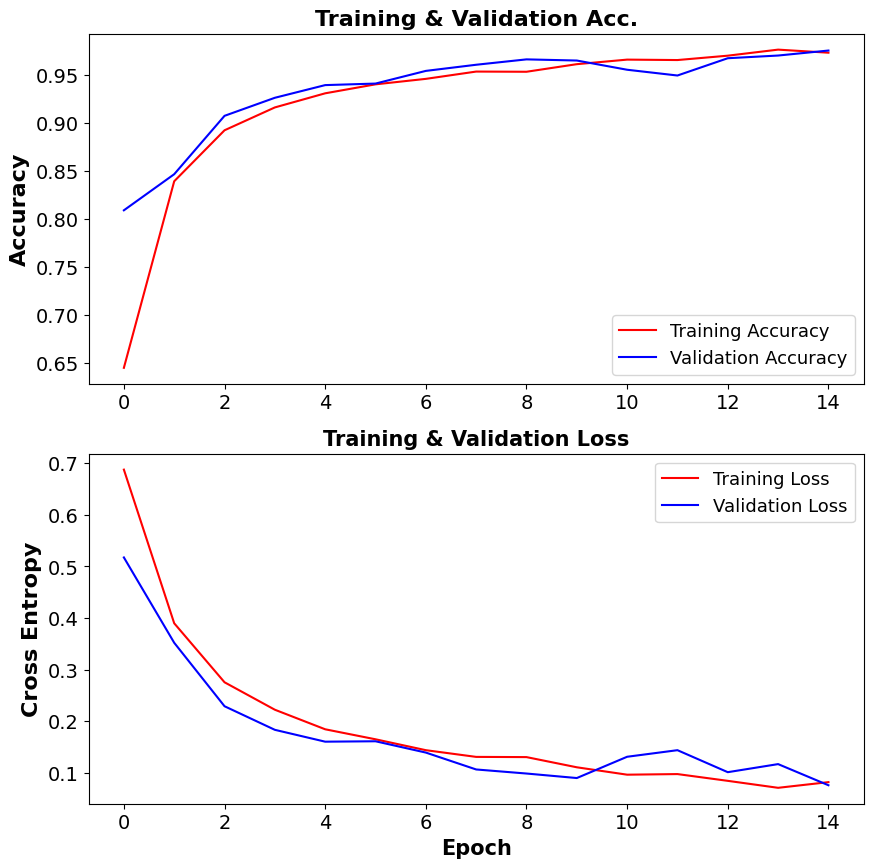

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()